In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torchvision.models as models


In [19]:
# Define transformations for training and validation data with data augmentation
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Imagenet standards
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Imagenet standards
])


In [38]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the dataset
full_dataset = ImageFolder(root="F:/FYP_save/dataset/colour/train/", transform=transform_train)
class_names = full_dataset.classes
print(len(class_names))

15


In [39]:
# K-Fold Cross Validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Training and validation
best_accuracy = 0.0

# To store loss and accuracy for each fold
train_loss_per_epoch = []
val_loss_per_epoch = []
train_acc_per_epoch = []
val_acc_per_epoch = []

for fold, (train_idx, val_idx) in enumerate(kf.split(full_dataset)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # Subset the dataset
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)
    
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4)
    
    # Define the model
    model = models.resnet18(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(class_names))
    model = model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Lists to store loss and accuracy for each epoch
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation loop
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
        
        val_loss = running_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Train Acc: {train_accuracy}, Val Acc: {val_accuracy}')
    
    # Append loss and accuracy for the fold
    train_loss_per_epoch.append(train_losses)
    val_loss_per_epoch.append(val_losses)
    train_acc_per_epoch.append(train_accuracies)
    val_acc_per_epoch.append(val_accuracies)
    
    # Save the best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), f'best_model_fold_{fold}.pth')

print(f'Best Validation Accuracy: {best_accuracy}')


Fold 1/5


c:\Users\ycloo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ycloo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10, Train Loss: 2.0914349653062776, Val Loss: 1.8760111715112413, Train Acc: 0.27387361858883535, Val Acc: 0.3314447592067989
Epoch 2/10, Train Loss: 1.9063126075321732, Val Loss: 1.7850881133760725, Train Acc: 0.323321054122981, Val Acc: 0.37393767705382436
Epoch 3/10, Train Loss: 1.7935552769656635, Val Loss: 1.6846111523253577, Train Acc: 0.3682346273731935, Val Acc: 0.4028328611898017
Epoch 4/10, Train Loss: 1.7356923058022202, Val Loss: 1.8097662787352289, Train Acc: 0.3818362142249929, Val Acc: 0.37223796033994333
Epoch 5/10, Train Loss: 1.697359258772561, Val Loss: 1.646753960422107, Train Acc: 0.39458770189855485, Val Acc: 0.4186968838526912
Epoch 6/10, Train Loss: 1.642847280157098, Val Loss: 1.6713135370186396, Train Acc: 0.4080476055539813, Val Acc: 0.39716713881019833
Epoch 7/10, Train Loss: 1.6107905995252445, Val Loss: 1.906583231474672, Train Acc: 0.42561632190422216, Val Acc: 0.32804532577903683
Epoch 8/10, Train Loss: 1.6003576557560744, Val Loss: 1.57778413008

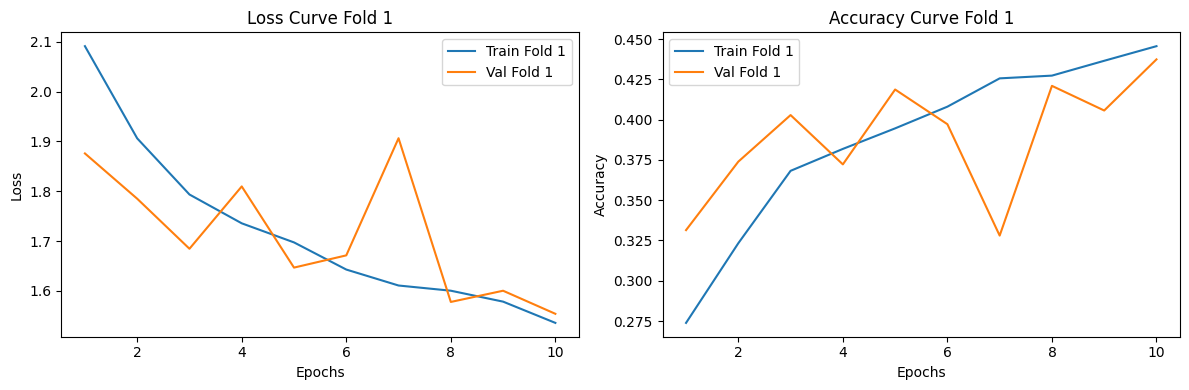

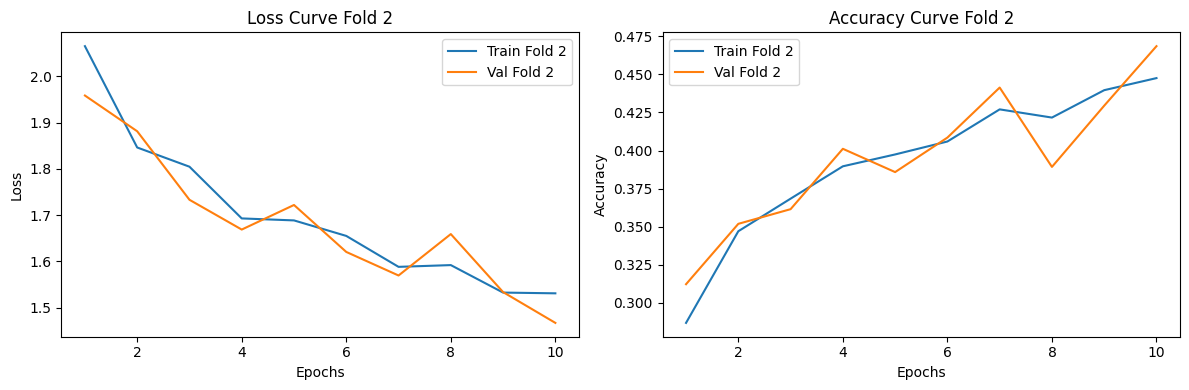

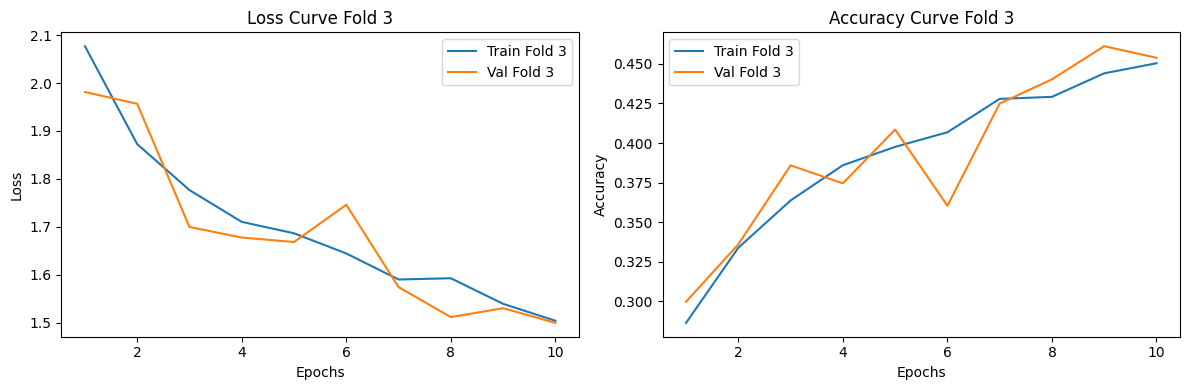

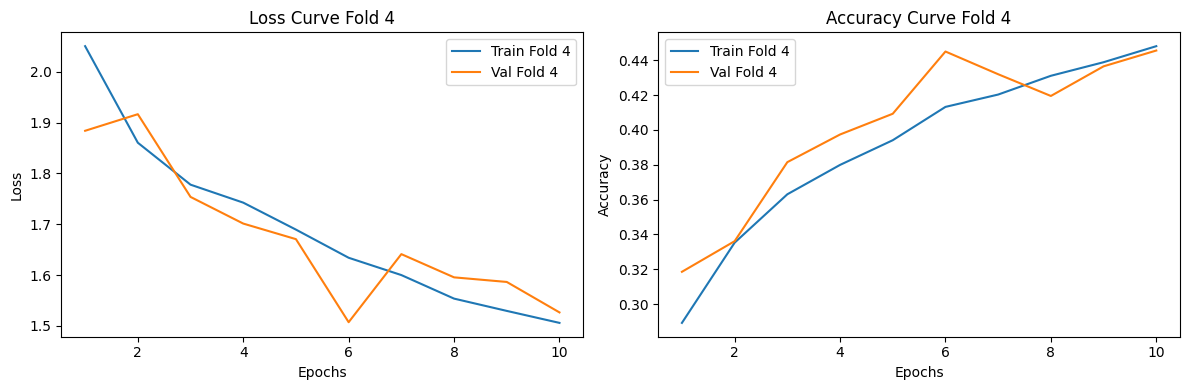

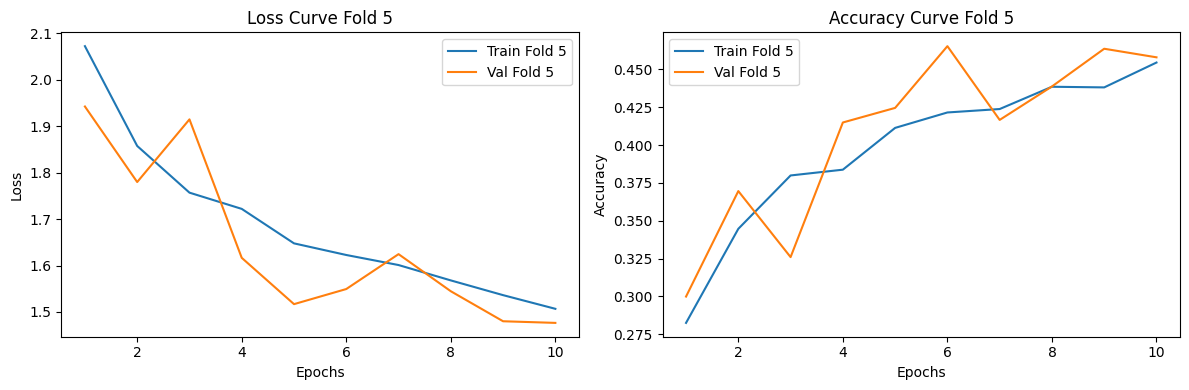

In [40]:
# Plotting loss and accuracy
epochs = range(1, num_epochs + 1)

for i in range(k_folds):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_per_epoch[i], label=f'Train Fold {i+1}')
    plt.plot(epochs, val_loss_per_epoch[i], label=f'Val Fold {i+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve Fold {i+1}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_per_epoch[i], label=f'Train Fold {i+1}')
    plt.plot(epochs, val_acc_per_epoch[i], label=f'Val Fold {i+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve Fold {i+1}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [41]:
# Function to predict the class of an input image using OpenCV
def predict_image_cv2(model, image_path, class_names):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = transform_input(image).unsqueeze(0)  # Add batch dimension
    
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]
    
    return predicted_class

In [42]:
# Function to load the model
def load_model(model_path, num_classes):
    model = torchvision.models.resnet18(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Define a transform for the input data (same as validation transform)
transform_input = transforms.Compose([
    transforms.ToPILImage(),  # Convert the image to PIL format
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Imagenet standards
])

In [44]:
# Load the trained model
colour_class = ['beige','black','blue','brown','gold','green','grey','orange','pink','purple','red','silver','tan','white','yellow']

num_classes = 15  # Assuming you have the dataset variable from training
model_path = 'googlenet_fold_1_epoch_50.pth'  # Path to the saved model
model = load_model(model_path, num_classes)


# Predict the class of a new image
image_path =  "F:\\FYP_save\\dataset\\colour\\val\\red\\0ae898eeac.jpg"
predicted_class = predict_image_cv2(model, image_path, colour_class)
print(f'Predicted class: {predicted_class}')

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "fold", "epoch", "model_state_dict", "optimizer_state_dict", "train_loss", "train_acc", "val_loss", "val_acc". 

In [26]:
print(len(dataset.classes))

2
